# OCR using CNN

## Importing required libraries

In [1]:
import tensorflow as tf
print("Tensorflow imported")
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

Tensorflow imported


Setting GPU memory growth limit to prevent Out of memory issues

In [2]:
gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)
gpus

[]

## Load Dataset
Load dataset from dataset folder in grayscale format with image size 60x40 px

In [90]:
data = tf.keras.utils.image_dataset_from_directory('dataset',image_size=(60,40),color_mode="grayscale")

Found 210227 files belonging to 62 classes.


Image data iterator used to access images stored in batches

In [91]:
data_iter = data.as_numpy_iterator()
data_iter

NumpyIterator(iterator=<tensorflow.python.data.ops.iterator_ops.OwnedIterator object at 0x000001EAE7855B50>)

Accessing next batch of images

In [92]:
batch = data_iter.next()

General lookup of how each batch variable looks and its shape <br>
Also the class names are printed

In [93]:
print(len(batch),batch[1],batch[0].shape)
print(data.class_names)
class_names = data.class_names

2 [56 18 45 44  8  7 19 57 26 19 60  8 19 24 22 56 60  5 35 24 13 31 33 18
 11 23 41 54 30 31 52  6] (32, 60, 40, 1)
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A_U', 'B_U', 'C_U', 'D_U', 'E_U', 'F_U', 'G_U', 'H_U', 'I_U', 'J_U', 'K_U', 'L_U', 'M_U', 'N_U', 'O_U', 'P_U', 'Q_U', 'R_U', 'S_U', 'T_U', 'U_U', 'V_U', 'W_U', 'X_U', 'Y_U', 'Z_U', 'a_L', 'b_L', 'c_L', 'd_L', 'e_L', 'f_L', 'g_L', 'h_L', 'i_L', 'j_L', 'k_L', 'l_L', 'm_L', 'n_L', 'o_L', 'p_L', 'q_L', 'r_L', 's_L', 't_L', 'u_L', 'v_L', 'w_L', 'x_L', 'y_L', 'z_L']


### Plotting data to check if the loading was right

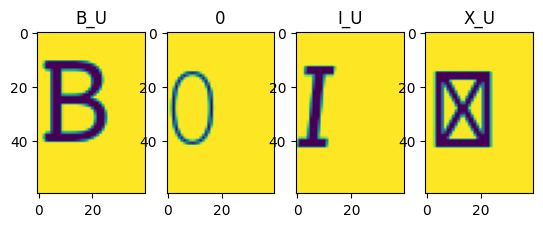

In [7]:
fig, ax = plt.subplots(1,4)
'''
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].set_title(class_names[batch[1][idx]])
'''

# Alternate way to view plots from tensorflow docs
for images, labels in data.take(1):
    for i in range(4):
        ax[i].imshow(images[i].numpy().astype(int))
        ax[i].set_title(class_names[labels[i]])
# print(img.shape)
#plt.imshow(img)

## Scale data
Scaling the image data from 0 to 1 so that tensorflow can run models in it properly

In [8]:
data = data.map(lambda x,y:(x/255,y))

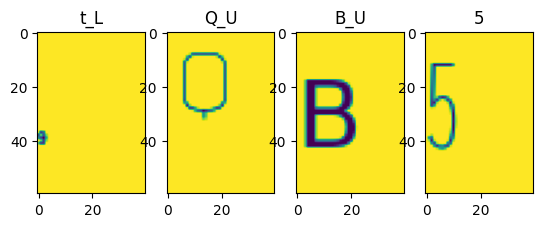

In [9]:
fig, ax = plt.subplots(1,4)
for images, labels in data.take(1):
    for i in range(4):
        ax[i].imshow(images[i].numpy())
        ax[i].set_title(class_names[labels[i]])
plt.show()

In [10]:
data_iter_val = data.as_numpy_iterator()

In [11]:
batch = data_iter_val.next()
print(batch[1])
batch[0].shape

[44 30  9 38 34 49 23 52 23 52 55 53 22 47 36 46 25  3  2 41 27 27 55 10
 56 16 25 45 38 41 58 35]


(32, 60, 40, 1)

## Splitting data
Train dataset size = 70% <br>
Testing dataset size = 20% <br>
Validation dataset size = 10%

In [69]:
train_size = int(len(data)*0.7)
val_size = int(len(data)*0.1)
test_size = int(len(data)*0.2)
print(f"Training dataset size: {train_size}\nVal. dataset size: {val_size}\nTest dataset size: {test_size}\nTotal: {len(data)}")
print(f"Total size after splitting: {train_size+test_size+val_size}")
print(f"Was the split right: {train_size+test_size+val_size==len(data)}")

Training dataset size: 4599
Val. dataset size: 657
Test dataset size: 1314
Total: 6570
Total size after splitting: 6570
Was the split right: True


In [13]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

## Training the Model!

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, AveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint

In [70]:
model = Sequential([
  Conv2D(32, 3, activation='relu', input_shape=(60,40,1),padding="same"), # padding is applied
    # Each filter is of dimension 3,3,1
  AveragePooling2D(pool_size=(2,2)), # The maximum value of 2x2 sub-matrix is taken

  Conv2D(32, 3, activation='relu'),
  AveragePooling2D(pool_size=2, padding="valid"),

  Conv2D(32, 3, activation='relu'),
  AveragePooling2D(pool_size=2, padding="valid"),

  Flatten(),
  Dense(62, activation='softmax') # changed to have 62 neurons (same as number of classes) and 'softmax' activation
])

C:\Users\Renata\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 60, 40, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 30, 20, 32)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 18, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 14, 9, 32)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 7, 32)      │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_2             │ (None, 6, 3, 32)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 62)             │        35,774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,590 (213.24 KB)

 Trainable params: 54,590 (213.24 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Define a Callback class that stops training once accuracy reaches 90%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.90):
      print("\nReached 90% accuracy so cancelling training!")
      self.model.stop_training = True

In [75]:
# Compile the model
model.compile(loss="sparse_categorical_crossentropy", # sparse categorical entropy in case of softmax acti. func.
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [76]:
#Fit the model
history = model.fit(train,
                    epochs=10,
                    validation_data=val,
                    callbacks=[ModelCheckpoint("./models/checkpoints_new/{epoch:02d}.keras",save_best_only=False,verbose=1),
                               tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)])

Epoch 1/10
4597/4599 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7944 - loss: 0.8638
Epoch 1: saving model to ./models/checkpoints_new/01.keras
4599/4599 ━━━━━━━━━━━━━━━━━━━━ 47s 10ms/step - accuracy: 0.7944 - loss: 0.8637 - val_accuracy: 0.8540 - val_loss: 0.5975
Epoch 2/10
4597/4599 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8630 - loss: 0.5450
Epoch 2: saving model to ./models/checkpoints_new/02.keras
4599/4599 ━━━━━━━━━━━━━━━━━━━━ 46s 10ms/step - accuracy: 0.8630 - loss: 0.5450 - val_accuracy: 0.8799 - val_loss: 0.4723
Epoch 3/10
4594/4599 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8814 - loss: 0.4544
Epoch 3: saving model to ./models/checkpoints_new/03.keras
4599/4599 ━━━━━━━━━━━━━━━━━━━━ 46s 10ms/step - accuracy: 0.8814 - loss: 0.4544 - val_accuracy: 0.8866 - val_loss: 0.4494
Epoch 4/10
4595/4599 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8922 - loss: 0.4059
Epoch 4: saving model to ./models/checkpoints_new/04.keras
4599/4599 ━━━━━━━━━━━━━━━━━━━━ 47s 10ms/step - ac

In [20]:
model.save("second_try.keras")

### Loss and Accuracy

In [77]:
epochs = [*range(1,11)]
plt.style.use(["seaborn-v0_8-darkgrid"])

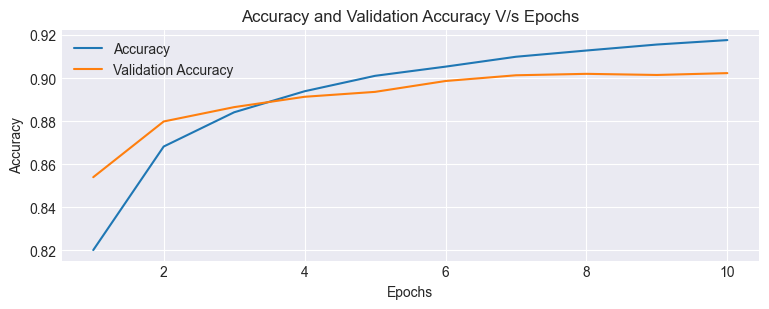

In [78]:
fig, ax = plt.subplots(1,1,figsize=(9,3))
ax.plot(epochs,history.history["accuracy"])
ax.plot(epochs,history.history["val_accuracy"])
ax.legend(["Accuracy","Validation Accuracy"])
ax.set_title("Accuracy and Validation Accuracy V/s Epochs")
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
plt.savefig("./models/model_perf/acc_plt.png",dpi=400)
plt.show(); plt.close()

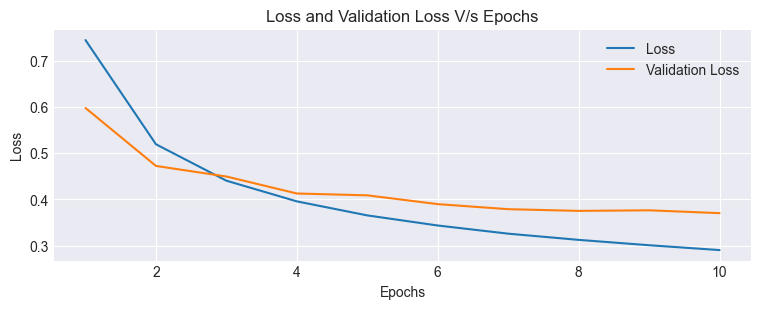

In [79]:
fig, ax = plt.subplots(1,1,figsize=(9,3))
epoch_range = range(1, len(history.history["loss"]) + 1)
ax.plot(epoch_range, history.history["loss"])
ax.plot(epoch_range, history.history["val_loss"])
ax.legend(["Loss","Validation Loss"])
ax.set_title("Loss and Validation Loss V/s Epochs")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
plt.savefig("./models/model_perf/loss_plt.png",dpi=400)
plt.show(); plt.close()

### Evaluate

In [24]:
from tensorflow.keras.models import load_model

In [80]:
loaded_model = load_model("./models/checkpoints_new/10.keras")

In [81]:
eval_data = loaded_model.evaluate(test)

1314/1314 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9016 - loss: 0.3761


In [82]:
print(eval_data)

[0.36875343322753906, 0.90424644947052]


In [83]:
# data_iter_val = test.as_numpy_iterator()
# test_batch = data_iter_val.next()
# print(test_batch)
predictions = np.array([])
labels = np.array([])

for x,y in test:
    predictions = np.concatenate([predictions,np.argmax(loaded_model.predict(x),axis=-1)])
    labels = np.concatenate([labels,y.numpy()])

#     print(y.numpy())
#     labels =  np.concatenate([labels,np.argmax(y.numpy(),axis=-1)])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━

In [29]:
print(predictions,labels)

[25. 22. 30. ...  1. 50. 55.] [25. 22. 30. ...  1. 50. 55.]


In [30]:
import seaborn as sns

In [31]:
conf_mat = tf.math.confusion_matrix(labels,predictions)

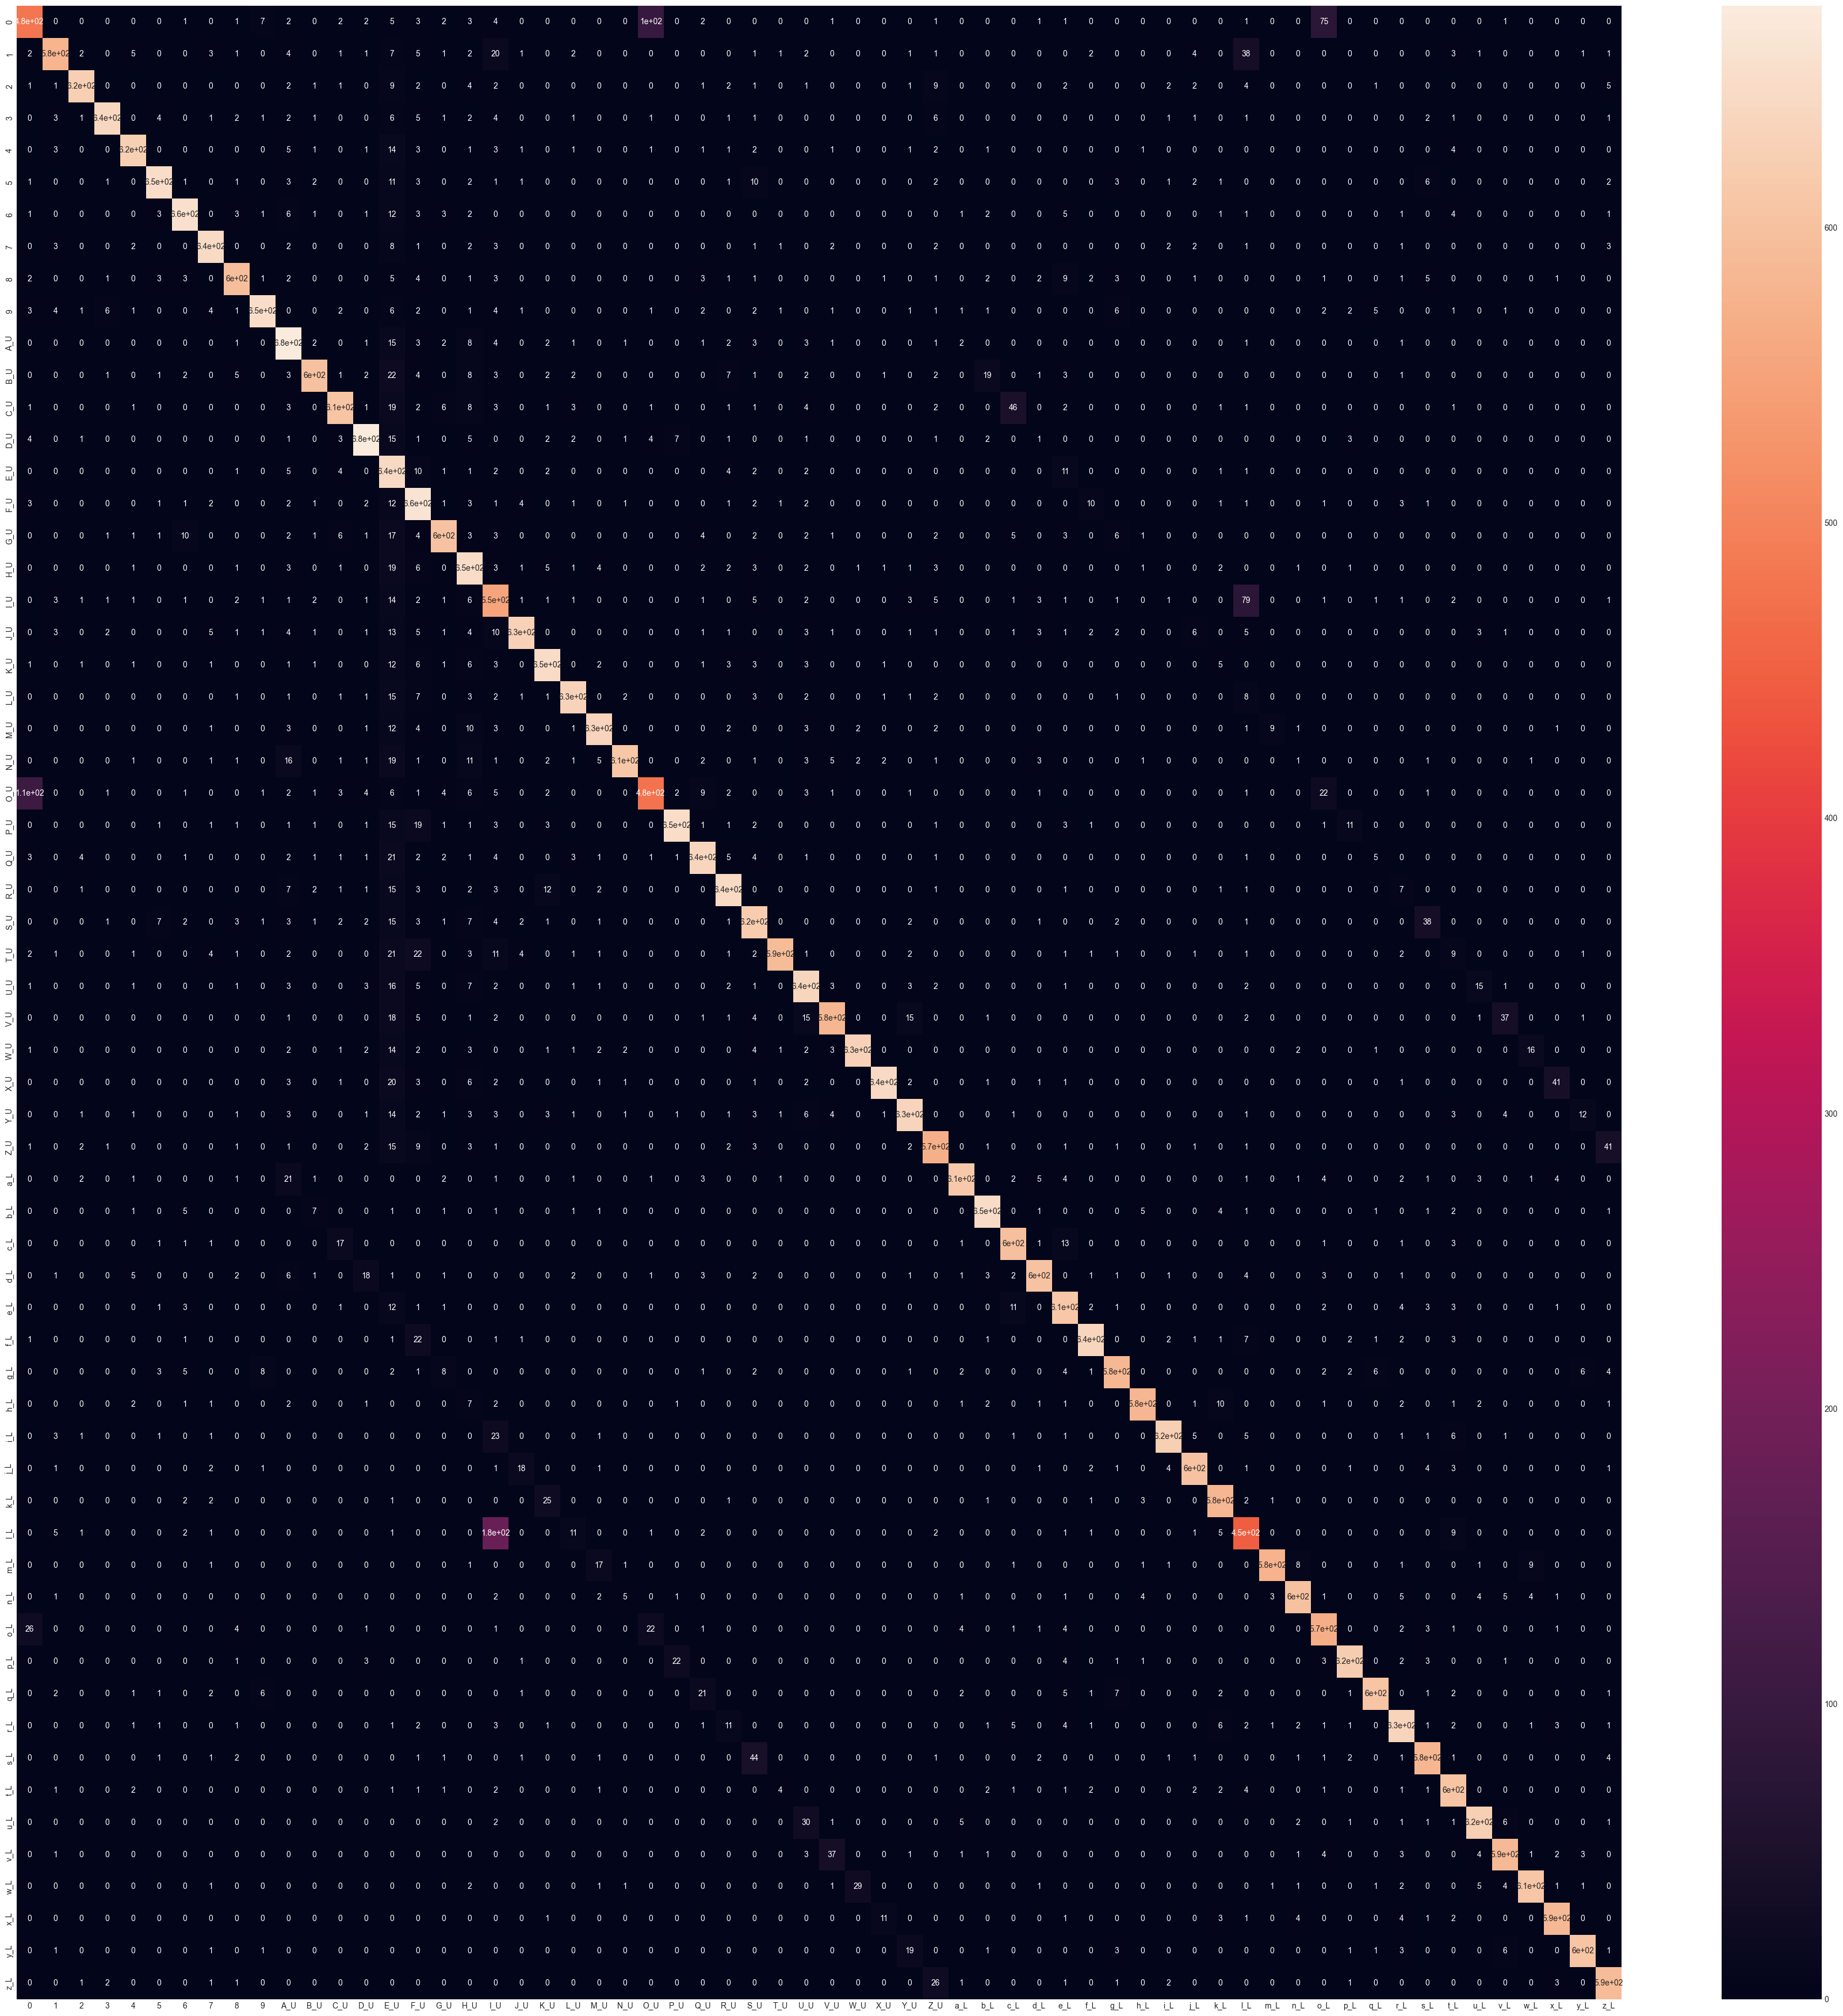

In [32]:
fig, ax = plt.subplots(figsize=(45,45))
sns.heatmap(conf_mat,ax=ax,annot=True)
ax.set_xticklabels(class_names)
ax.set_yticklabels(class_names)
plt.savefig("./models/conf_matrix_new.png",dpi=400)

### Random Test

In [33]:
import random

In [34]:
def load_random():
    ranges = [*range(0,1000,1)]
    values = random.choices(ranges,k=62)
    images = list()
    for i in range(len(values)):
        if i<10:
            img = cv2.imread(f"./dataset/{i}/{values[i]}.png")
        else:
            img = cv2.imread(f"./dataset/{class_names[i]}/{class_names[i]}_{values[i]}.png")
        if img is not None:
            images.append(img)
        else:
            if i<10:
                img = cv2.imread(f"./dataset/{i}/1.png")
            else:
                img = cv2.imread(f"./dataset/{class_names[i]}/{class_names[i]}_1.png")
#             while True:
#                 val = values[i]
#                 if i<10:
#                     img = cv2.imread(f"./dataset/{i}/{val+1}.png")
#                 else:
#                     print("whoa")
#                     img = cv2.imread(f"./dataset/{class_names[i]}/{class_names[i]}_{val+1}.png")
#                 if img is not None:
#                     break
#                 else:
#                     val +=1
    return images


def plot_those_imgs(images,**kwargs):
    fig, ax = plt.subplots(8,8,figsize=(16,16))
    fig.tight_layout()
    for i in range(len(images)):
        ax[i//8,i%8].imshow(images[i])
        if len(kwargs)==0:
            ax[i//8,i%8].title.set_text(f"{class_names[i]}")
        else:
            ax[i//8,i%8].title.set_text(f"{class_names[i]} - {kwargs['acc'][i]}")
    plt.show()

60
60
61


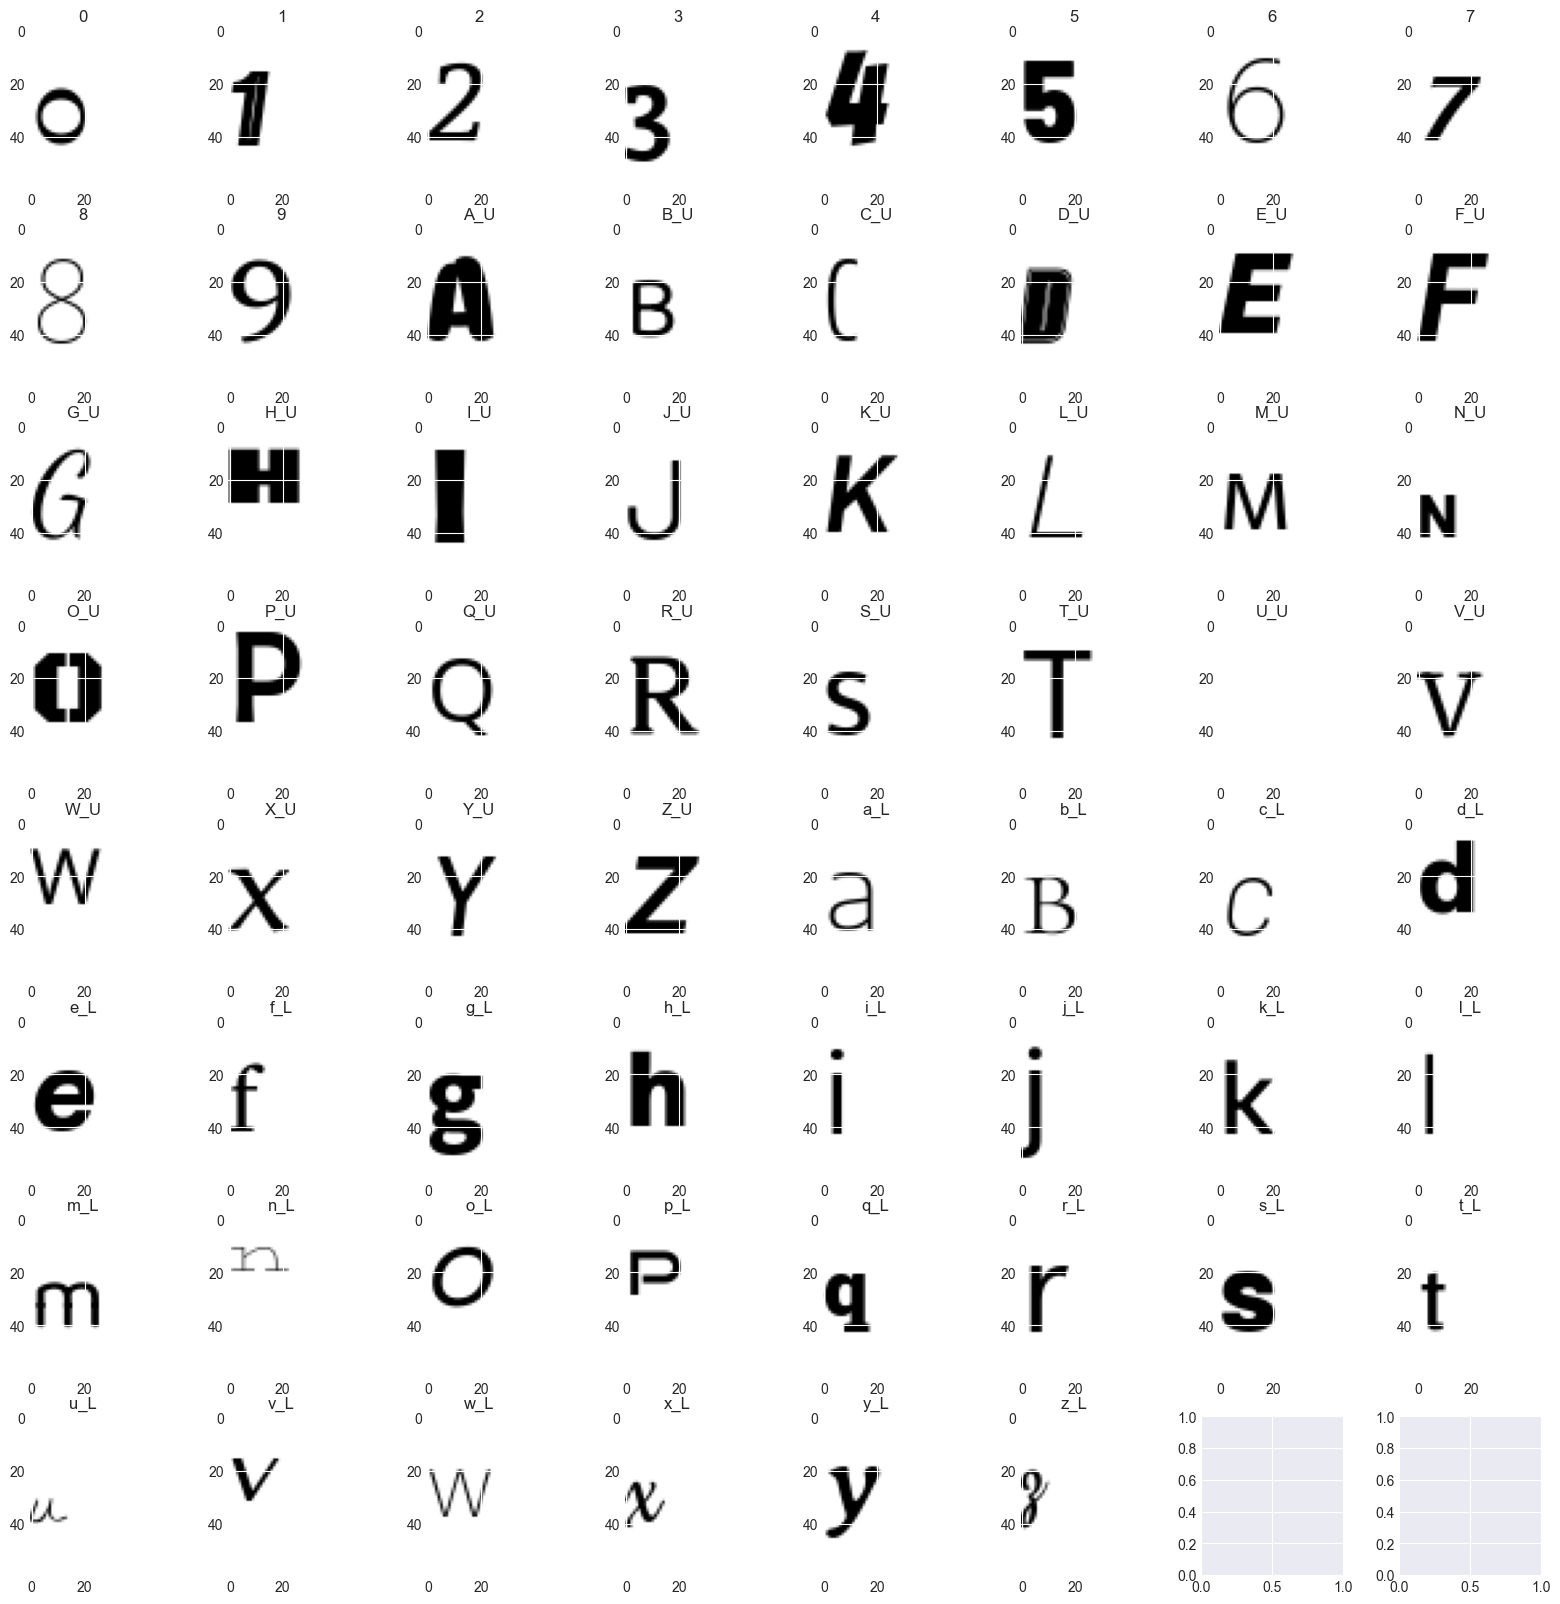

In [35]:
while True:
    images = load_random()
    if len(images)==62:
        break
    print(len(images))

plot_those_imgs(images)

plt.close()

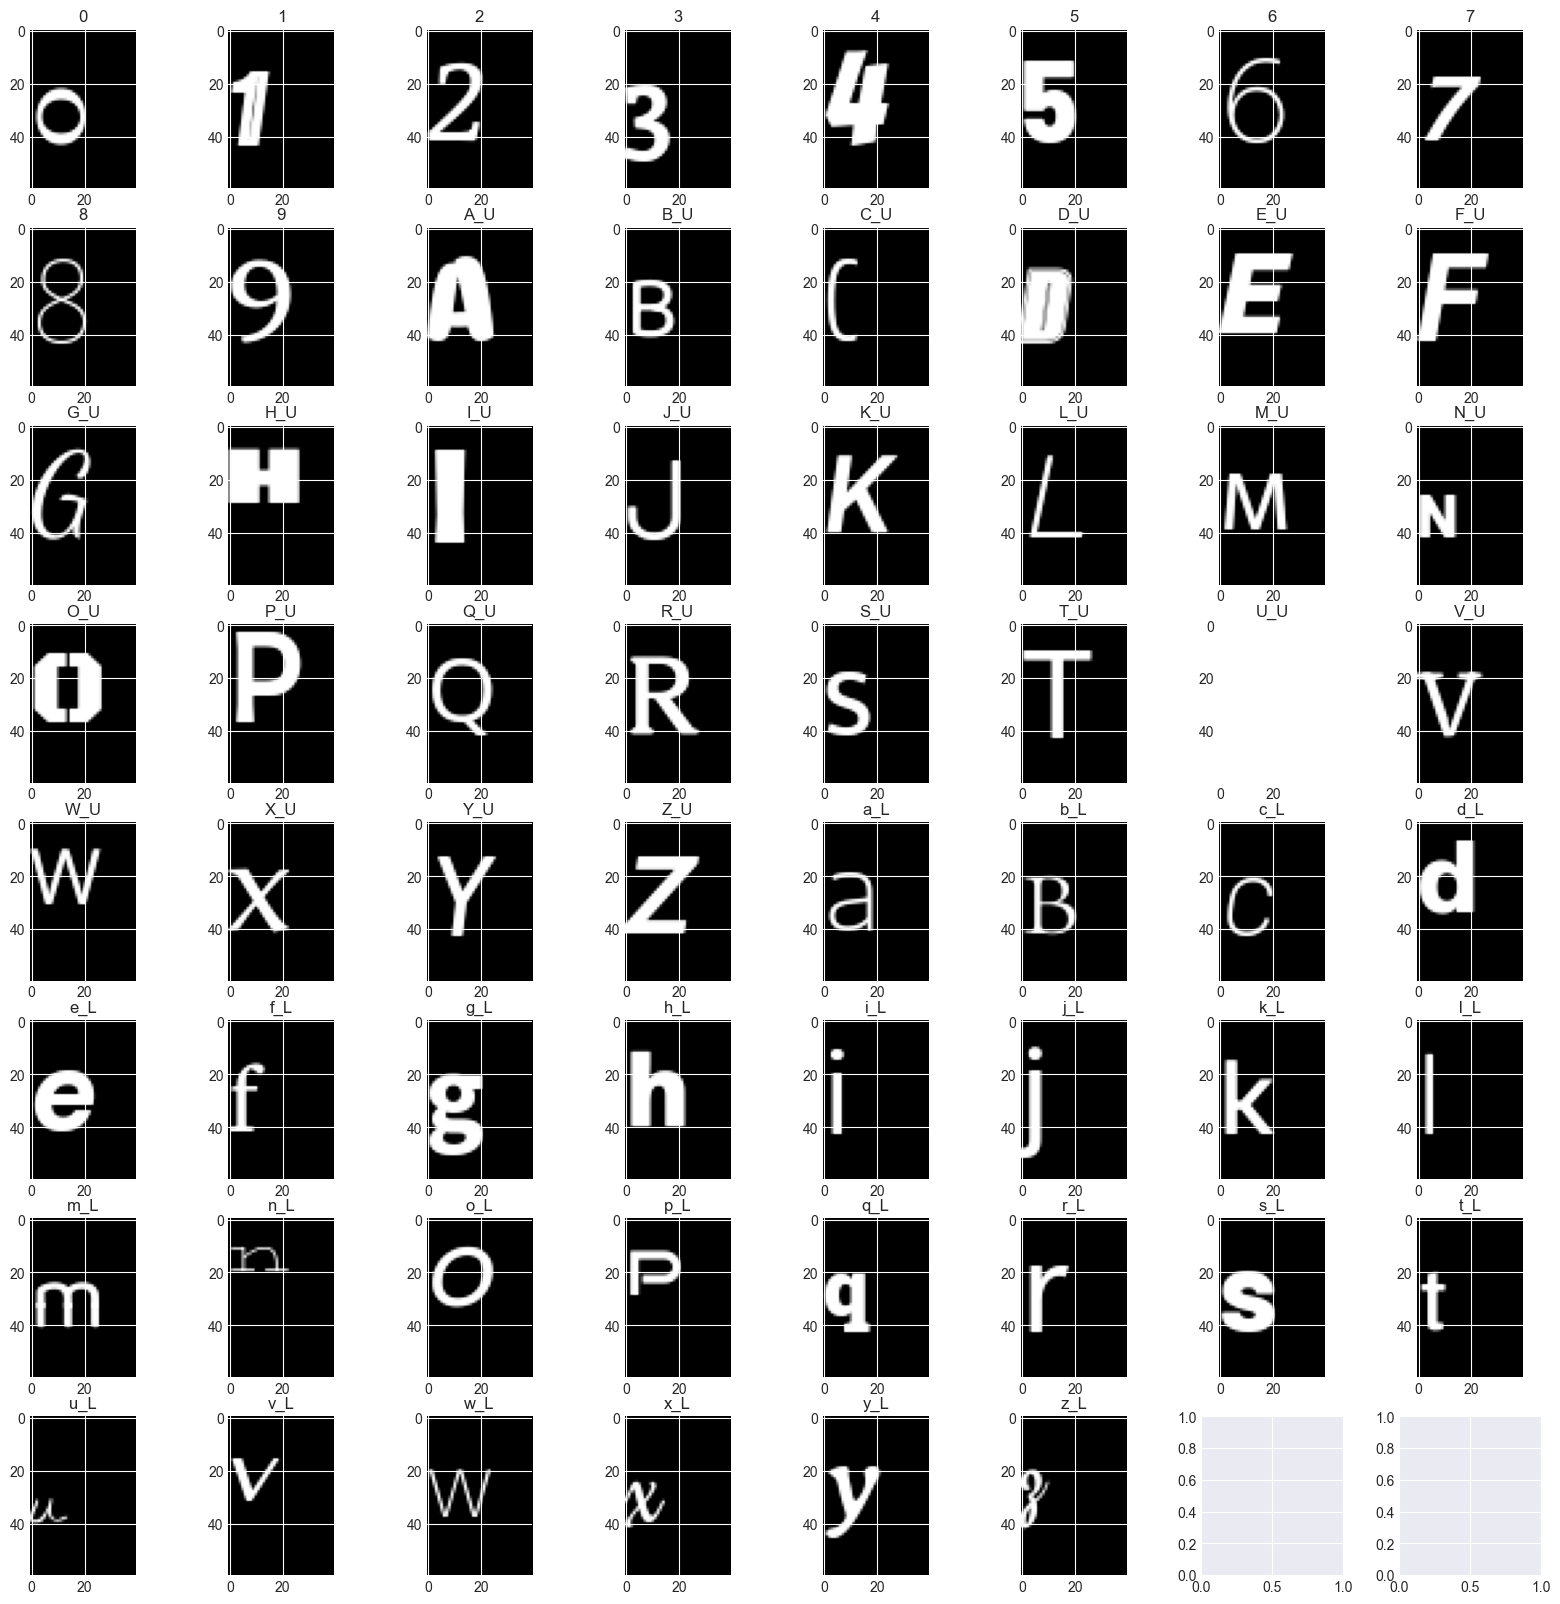

In [37]:
resize = tf.image.resize(tf.image.rgb_to_grayscale(images),(60,40))
plot_those_imgs(resize)

In [39]:
yhat = loaded_model.predict(*np.expand_dims(resize/255, 0))
yhat

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


array([[9.72507372e-02, 2.79745302e-13, 4.51624918e-11, ...,
        4.04987895e-06, 1.79309353e-13, 1.00465324e-13],
       [5.89004543e-08, 9.68104362e-01, 6.27812138e-03, ...,
        1.09814255e-08, 6.55700774e-07, 6.36390105e-05],
       [7.79521901e-13, 1.36560099e-12, 9.99890208e-01, ...,
        8.24588287e-10, 4.31557728e-16, 1.41384122e-08],
       ...,
       [1.82563846e-04, 5.39361354e-05, 1.06387695e-07, ...,
        4.77058172e-01, 3.17881955e-03, 1.95757584e-05],
       [1.78699297e-12, 4.53045212e-10, 1.53771429e-14, ...,
        2.54194132e-09, 9.99718368e-01, 1.53909677e-10],
       [8.38651467e-05, 3.16182291e-03, 8.79187428e-05, ...,
        1.48775661e-02, 6.50698483e-01, 8.88240188e-02]], dtype=float32)

['0.87 - o_L', '0.97 - 1', '1.0 - 2', '0.99 - 3', '1.0 - 4', '1.0 - 5', '1.0 - 6', '1.0 - 7', '1.0 - 8', '1.0 - 9', '1.0 - A_U', '0.86 - B_U', '0.86 - C_U', '0.76 - D_U', '1.0 - E_U', '1.0 - F_U', '0.91 - G_U', '0.95 - H_U', '0.65 - I_U', '0.98 - J_U', '1.0 - K_U', '0.99 - L_U', '1.0 - M_U', '0.93 - N_U', '0.83 - O_U', '1.0 - P_U', '1.0 - Q_U', '1.0 - R_U', '0.9 - S_U', '1.0 - T_U', '0.03 - H_U', '0.86 - V_U', '1.0 - W_U', '0.65 - x_L', '1.0 - Y_U', '1.0 - Z_U', '0.98 - a_L', '0.95 - b_L', '0.99 - c_L', '1.0 - d_L', '1.0 - e_L', '1.0 - f_L', '1.0 - g_L', '1.0 - h_L', '0.99 - i_L', '1.0 - j_L', '1.0 - k_L', '0.6 - I_U', '1.0 - m_L', '0.63 - n_L', '0.78 - O_U', '0.49 - p_L', '0.98 - q_L', '1.0 - r_L', '0.99 - s_L', '0.96 - t_L', '0.13 - L_U', '1.0 - v_L', '0.85 - w_L', '0.48 - x_L', '1.0 - y_L', '0.65 - y_L']


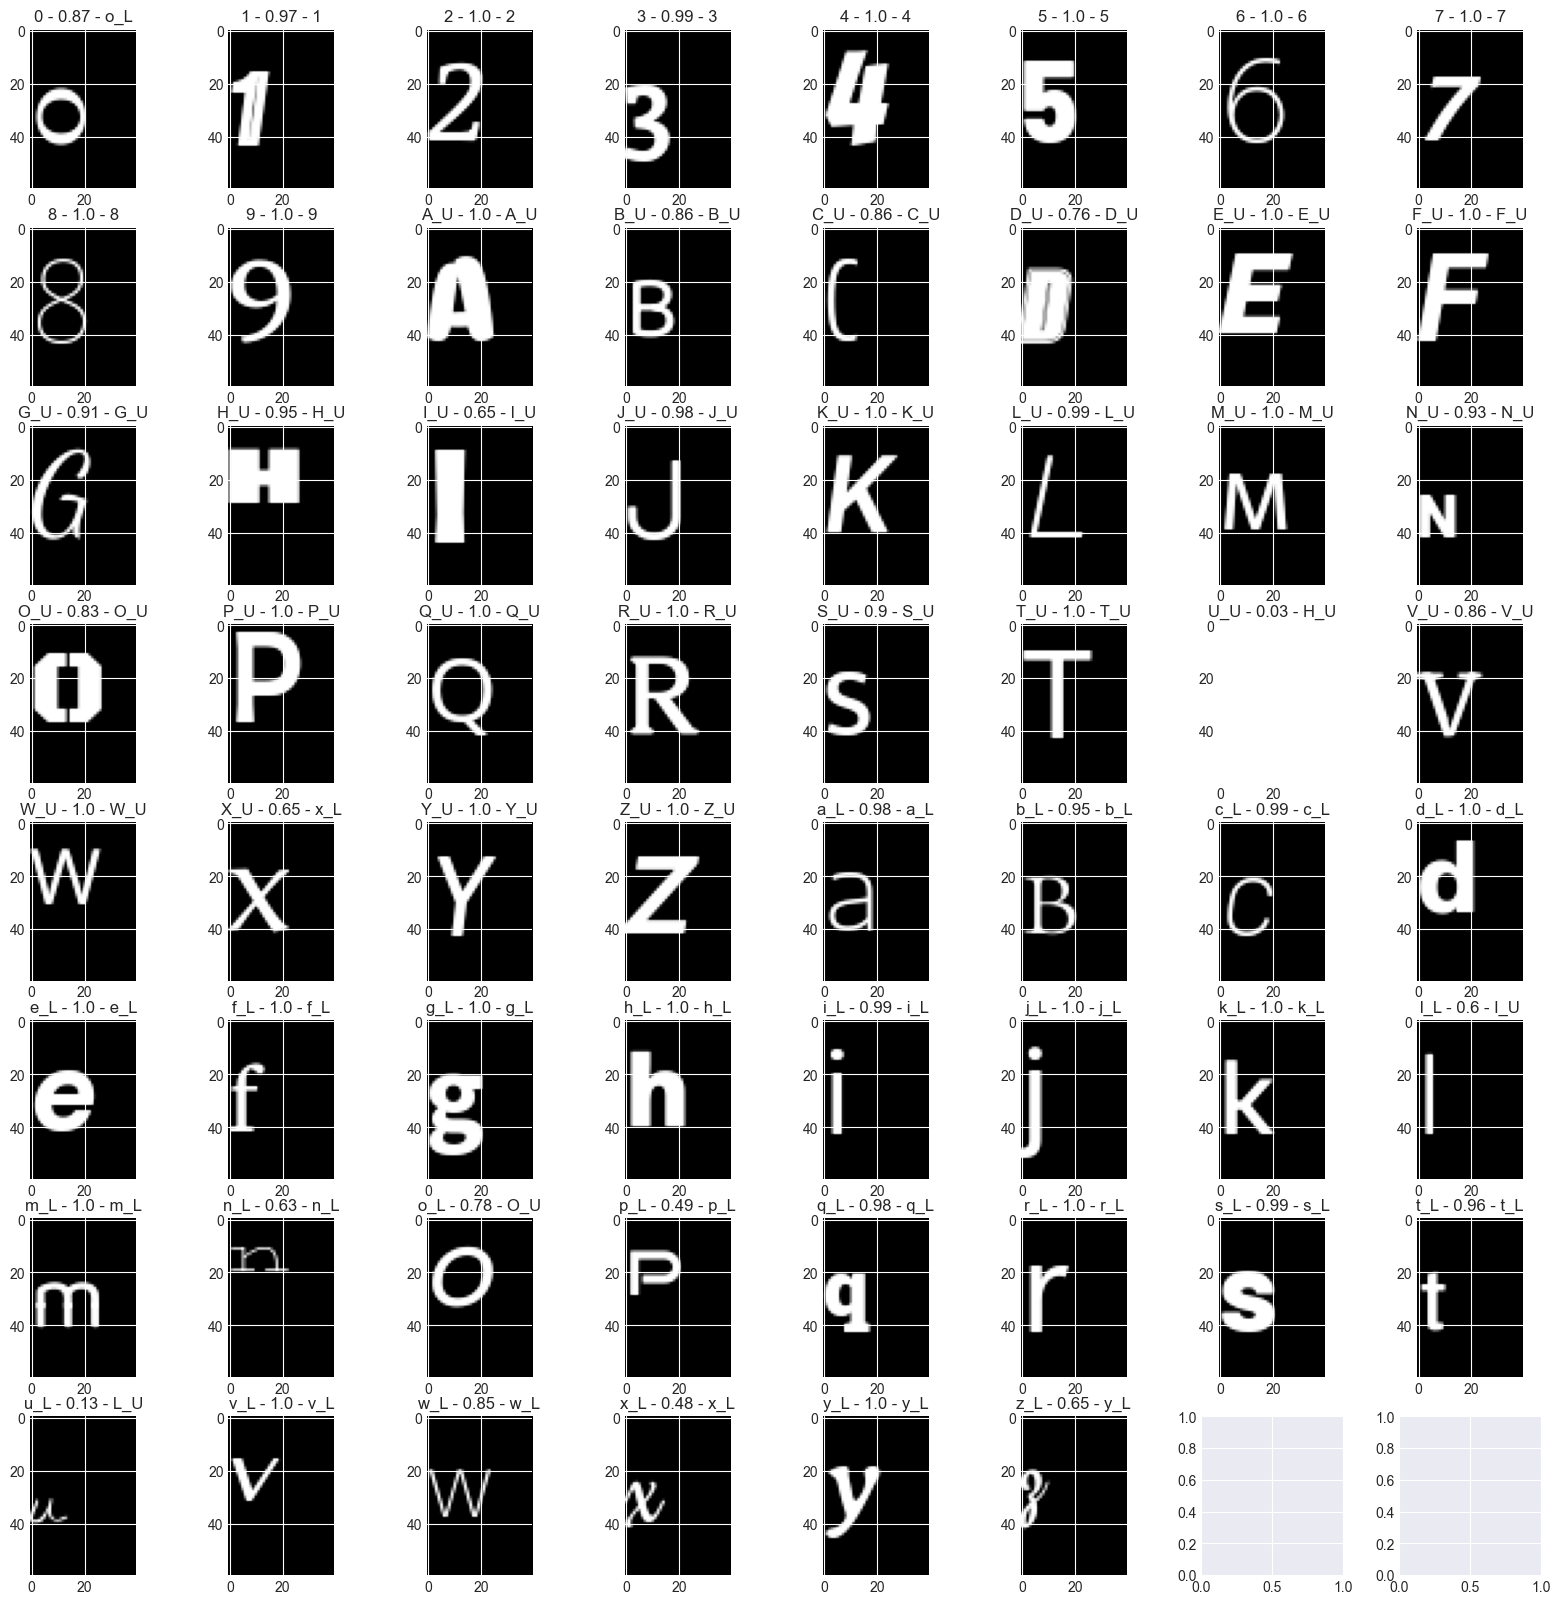

In [40]:
acc_pred = [f"{round(float(yhat[i][np.argmax(yhat[i])]),2)} - {class_names[np.argmax(yhat[i])]}" for i in range(len(yhat))]
print(acc_pred)
plot_those_imgs(resize,acc=acc_pred)

# TEST

In [99]:
import tensorflow as tf
import numpy as np
import cv2
import os
from tensorflow.keras.models import load_model
from PIL import Image, ImageDraw, ImageFont
import copy

model_path = "./models/checkpoints_new/10.keras"
loaded_model = None

try:
    loaded_model = load_model(model_path)
except Exception:
    exit()

def clean_label(label):
    if '_U' in label:
        return label.replace('_U', '')
    elif '_L' in label:
        return label.replace('_L', '').lower()
    else:
        return label

def simulate_scan_preserving_music_details(img_input):
    gray = cv2.cvtColor(img_input, cv2.COLOR_BGR2GRAY)
    min_val, max_val = np.percentile(gray, (1, 80))
    stretched = np.clip((gray - min_val) * 255.0 / (max_val - min_val + 1e-4), 0, 255).astype(np.uint8)
    _, thresh = cv2.threshold(stretched, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    return thresh

def ocr_full_page(image_path: str, model: tf.keras.Model, class_names: list) -> str:
    try:
        img_original = cv2.imread(image_path)
        if img_original is None:
            return ""

        processed_img = simulate_scan_preserving_music_details(img_original)
        cv2.imwrite("debug_processed_image.png", processed_img)

        contours, _ = cv2.findContours(processed_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        img_contours_debug = img_original.copy()
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            cv2.rectangle(img_contours_debug, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.imwrite("debug_contours_boxes.png", img_contours_debug)

        contours = sorted(contours, key=lambda ctr: (cv2.boundingRect(ctr)[1], cv2.boundingRect(ctr)[0]))

        extracted_text = []
        previous_char_x_end = 0
        previous_char_y = 0
        line_height_threshold = 20
        space_width_threshold = 10

        model_input_height = 60
        model_input_width = 40

        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)

            if 10 < w < 100 and 20 < h < 100:
                
                if previous_char_y != 0 and y > previous_char_y + line_height_threshold:
                    extracted_text.append('\n')
                    previous_char_x_end = 0

                if previous_char_x_end != 0 and x > previous_char_x_end + space_width_threshold:
                    extracted_text.append(' ')

                char_img_roi = processed_img[y:y+h, x:x+w]
                char_img_roi = cv2.bitwise_not(char_img_roi)
                char_img_resized = cv2.resize(char_img_roi, (model_input_width, model_input_height))
                char_img_normalized = char_img_resized.astype(np.float32) / 255.0
                input_tensor = np.expand_dims(np.expand_dims(char_img_normalized, axis=0), axis=-1)

                predictions = model.predict(input_tensor, verbose=0)
                predicted_character = clean_label(class_names[np.argmax(predictions)])
                extracted_text.append(predicted_character)

                previous_char_x_end = x + w
                previous_char_y = y

        return "".join(extracted_text)

    except Exception:
        return ""

if __name__ == "__main__":
    image_to_process = "sample_page.png"
    if loaded_model:
        recognized_text = ocr_full_page(image_to_process, loaded_model, class_names)
        print(recognized_text)

m f rf m mf
ffm 7 m9pfq
m m m Uy mm mf q


In [94]:
import cv2
import numpy as np

def clean_label(label):
    if '_U' in label:
        return label.replace('_U', '')
    elif '_L' in label:
        return label.replace('_L', '').lower()
    return label

def pad_and_resize(roi, target_size=(60, 40)):
    h, w = roi.shape
    scale = min(target_size[0]/h, target_size[1]/w)
    nh, nw = int(h * scale), int(w * scale)
    roi_resized = cv2.resize(roi, (nw, nh), interpolation=cv2.INTER_AREA)
    top = (target_size[0] - nh) // 2
    bottom = target_size[0] - nh - top
    left = (target_size[1] - nw) // 2
    right = target_size[1] - nw - left
    padded = cv2.copyMakeBorder(roi_resized, top, bottom, left, right, cv2.BORDER_CONSTANT, value=0)
    return padded

def preprocess_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        return None, None
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (3, 3), 0)
    _, binary = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    return img, binary

def ocr_image(image_path, model, class_names):
    original, processed = preprocess_image(image_path)
    if original is None or processed is None:
        print("Eroare la citirea imaginii.")
        return ""

    contours, _ = cv2.findContours(processed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=lambda c: (cv2.boundingRect(c)[1], cv2.boundingRect(c)[0]))

    result_img = original.copy()
    result_text = []

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if w < 2 or h < 5 or w > 100 or h > 100:
            continue

        roi = processed[y:y+h, x:x+w]
        roi = pad_and_resize(roi, target_size=(60, 40))
        input_tensor = np.expand_dims(np.expand_dims(roi / 255.0, axis=0), axis=-1)
        prediction = model.predict(input_tensor, verbose=0)
        predicted_label = clean_label(class_names[np.argmax(prediction)])
        result_text.append(predicted_label)

        cv2.rectangle(result_img, (x, y), (x+w, y+h), (0, 255, 0), 1)
        cv2.putText(result_img, predicted_label, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 1)

    cv2.imwrite("output_with_boxes.png", result_img)
    return "".join(result_text)

# Execută OCR pe imagine folosind variabilele deja definite în notebook
model_path = "./models/checkpoints_new/10.keras"
model = load_model(model_path)
text_result = ocr_image("test.png", model, class_names)
print("Text detectat:\n", text_result)


Text detectat:
 m7gmfD7mmmmmmmmmAmAgpf4fmffyffAfr2m4ggmmffffffgIZffmmyffAfIgyjfAmGmmmfmfpf9pm742r67mffImffpyff2jfT4ffjfffgmm74262ppyfyfQfmpffy7f25I94f7mmm742rmfjfffgDypyffImffpyff2r7gmm74myl9jfpjfffgyfgfflmf2r67gmmfpyff2jfT4ffjfffppyfy


In [109]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler
import joblib

def clean_label(label):
    if '_U' in label:
        return label.replace('_U', '')
    elif '_L' in label:
        return label.replace('_L', '').lower()
    else:
        return label

def simulate_scan_preserving_music_details(img_input):
    gray = cv2.cvtColor(img_input, cv2.COLOR_BGR2GRAY)
    # Try inverting if needed
    # gray = cv2.bitwise_not(gray)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    return thresh

def ocr_full_page(image_path: str, model, class_names: list) -> str:
    try:
        img_original = cv2.imread(image_path)
        if img_original is None:
            return ""

        processed_img = simulate_scan_preserving_music_details(img_original)
        cv2.imwrite("debug_processed_image.png", processed_img)

        # Find contours with better parameters
        contours, _ = cv2.findContours(
            processed_img, 
            cv2.RETR_EXTERNAL, 
            cv2.CHAIN_APPROX_SIMPLE
        )

        # Draw contours for debugging
        img_contours_debug = img_original.copy()
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            cv2.rectangle(img_contours_debug, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.imwrite("debug_contours_boxes.png", img_contours_debug)

        # Sort contours by position (top to bottom, left to right)
        contours = sorted(contours, key=lambda ctr: (cv2.boundingRect(ctr)[1] // 30, cv2.boundingRect(ctr)[0]))

        extracted_text = []
        previous_char_x_end = 0
        previous_char_y = 0
        line_height_threshold = 25  # Increased for better line separation
        space_width_threshold = 15   # Increased for better space detection

        model_input_height = 60
        model_input_width = 40

        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            
            # Adjusted character size thresholds
            if 12 < w < 60 and 20 < h < 60:  # More strict size limits
                if previous_char_y != 0 and y > previous_char_y + line_height_threshold:
                    extracted_text.append('\n')
                    previous_char_x_end = 0

                if previous_char_x_end != 0 and x > previous_char_x_end + space_width_threshold:
                    extracted_text.append(' ')

                # Extract and preprocess character
                char_img_roi = processed_img[y:y+h, x:x+w]
                
                # Add padding to maintain aspect ratio
                pad_x = max(0, (h - w) // 2)
                pad_y = max(0, (w - h) // 2)
                char_img_roi = cv2.copyMakeBorder(
                    char_img_roi,
                    pad_y, pad_y, pad_x, pad_x,
                    cv2.BORDER_CONSTANT,
                    value=0
                )
                
                # Resize to model input size
                char_img_resized = cv2.resize(char_img_roi, (model_input_width, model_input_height))
                
                # Normalize and prepare for model
                char_img_normalized = char_img_resized.astype(np.float32) / 255.0
                input_tensor = np.expand_dims(np.expand_dims(char_img_normalized, axis=0), axis=-1)

                # Get prediction with confidence threshold
                predictions = model.predict(input_tensor, verbose=0)
                max_prob = np.max(predictions)
                if max_prob > 0.5:  # Only accept predictions with high confidence
                    predicted_character = clean_label(class_names[np.argmax(predictions)])
                    extracted_text.append(predicted_character)
                else:
                    extracted_text.append('?')  # Mark uncertain predictions

                previous_char_x_end = x + w
                previous_char_y = y

        return "".join(extracted_text)

    except Exception as e:
        print(f"Error in OCR processing: {str(e)}")
        return ""

def ocr_with_visualization(image_path: str, model, class_names: list, output_img_path="ocr_result_with_boxes.png") -> str:
    img_original = cv2.imread(image_path)
    if img_original is None:
        print("Image not found.")
        return ""
    processed_img = simulate_scan_preserving_music_details(img_original)
    result_img = img_original.copy()
    result_text = []

    contours, _ = cv2.findContours(processed_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=lambda ctr: (cv2.boundingRect(ctr)[1] // 30, cv2.boundingRect(ctr)[0]))

    model_input_height = 60
    model_input_width = 40

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if w < 2 or h < 20 or w > 60 or h > 60:
            continue

        char_img_roi = processed_img[y:y+h, x:x+w]
        pad_x = max(0, (h - w) // 2)
        pad_y = max(0, (w - h) // 2)
        char_img_roi = cv2.copyMakeBorder(
            char_img_roi,
            pad_y, pad_y, pad_x, pad_x,
            cv2.BORDER_CONSTANT,
            value=0
        )
        char_img_resized = cv2.resize(char_img_roi, (model_input_width, model_input_height))
        char_img_normalized = char_img_resized.astype(np.float32) / 255.0
        input_tensor = np.expand_dims(np.expand_dims(char_img_normalized, axis=0), axis=-1)

        predictions = model.predict(input_tensor, verbose=0)
        predicted_label = clean_label(class_names[np.argmax(predictions)])
        result_text.append(predicted_label)

        cv2.rectangle(result_img, (x, y), (x+w, y+h), (0, 255, 0), 1)
        cv2.putText(result_img, predicted_label, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 1)

    cv2.imwrite(output_img_path, result_img)
    return "".join(result_text)

def main():
    # Define class names (these should match your training data classes)
    class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
                   'A_U', 'B_U', 'C_U', 'D_U', 'E_U', 'F_U', 'G_U', 
                   'H_U', 'I_U', 'J_U', 'K_U', 'L_U', 'M_U', 'N_U', 
                   'O_U', 'P_U', 'Q_U', 'R_U', 'S_U', 'T_U', 'U_U', 
                   'V_U', 'W_U', 'X_U', 'Y_U', 'Z_U', 'a_L', 'b_L', 
                   'c_L', 'd_L', 'e_L', 'f_L', 'g_L', 'h_L', 'i_L', 
                   'j_L', 'k_L', 'l_L', 'm_L', 'n_L', 'o_L', 'p_L', 
                   'q_L', 'r_L', 's_L', 't_L', 'u_L', 'v_L', 'w_L', 
                   'x_L', 'y_L', 'z_L']
    
    # Load model
    model_path = "./models/checkpoints_new/10.keras"
    
    try:
        model = load_model(model_path)
        print("Model loaded successfully")
    except Exception as e:
        print(f"Error loading model: {str(e)}")
        return
    
    # Process image if provided
    image_to_process = "sample_page.png"
    if os.path.exists(image_to_process):
        recognized_text = ocr_with_visualization(image_to_process, model, class_names)
        print("Recognized text:")
        print(recognized_text)
        print("Output image with boxes and labels saved as ocr_result_with_boxes.png")
    else:
        print(f"Image file {image_to_process} not found")

if __name__ == "__main__":
    main()

Model loaded successfully
Recognized text:
fjjfjfffffff4IfAmyyffjmfff4ffRA
Output image with boxes and labels saved as ocr_result_with_boxes.png
